In [135]:
import pandas as pd
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, AvgPool1D, Input, Conv1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [136]:
# Load the CSV file
df = pd.read_csv('./data/point_history.csv', header = None)

# Extract the class labels
labels = df.iloc[:, 0].values-1

# Extract and preprocess the JSON data
def preprocess_json(json_str):
    # Parse the JSON string
    history_points = json.loads(json_str)
    
    # Flatten the list of landmarks into a single list
    points_array = []
    for _, values in history_points.items():
        flattened_points = []
        for point in values:
            flattened_points.extend([point['X'], point['Y']])
        points_array.append(flattened_points)

    return points_array

# Apply preprocessing to each row in the second column
features = np.array([preprocess_json(json_str) for json_str in df.iloc[:, 1]])

# Convert labels to one-hot encoding if needed
num_classes = len(np.unique(labels))
#labels = tf.keras.utils.to_categorical(labels, num_classes)
labels = ((labels==0).astype(float)) #because "2 was negative"


In [137]:
np.shape(features)

(568, 50, 42)

In [138]:
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(50, 42)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(16, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Using sigmoid for binary classification
])



# Compile the model
model.compile(optimizer=Adam(ExponentialDecay(
0.01, 200, 0.7)), loss='BinaryFocalCrossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


c:\Users\simon\anaconda3\envs\cv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 50, 32)         │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,209 (55.50 KB)

 Trainable params: 14,017 (54.75 KB)

 Non-trainable params: 192 (768.00 B)

In [139]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [140]:
#callbacks
callbacks = [ModelCheckpoint(monitor="val_loss", save_best_only=True, filepath="./models/waving.keras", verbose=True), EarlyStopping(monitor="val_loss", patience=50)]

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, callbacks = callbacks, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')


Epoch 1/150


13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5313 - loss: 0.4457
Epoch 1: val_loss improved from inf to 0.16613, saving model to ./models/waving.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5431 - loss: 0.4266 - val_accuracy: 0.5789 - val_loss: 0.1661
Epoch 2/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6917 - loss: 0.2008
Epoch 2: val_loss did not improve from 0.16613
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7011 - loss: 0.1960 - val_accuracy: 0.5789 - val_loss: 0.1806
Epoch 3/150
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7822 - loss: 0.1517
Epoch 3: val_loss did not improve from 0.16613
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7799 - loss: 0.1514 - val_accuracy: 0.5789 - val_loss: 0.1748
Epoch 4/150
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8096 - loss: 0.1286
Epoch 4: val_loss did not improve from 0.16613
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8119 - loss: 0.1267 - val_accuracy: 0.5

In [12]:
model.save("./models/waving.keras")

In [141]:
def plot_history(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

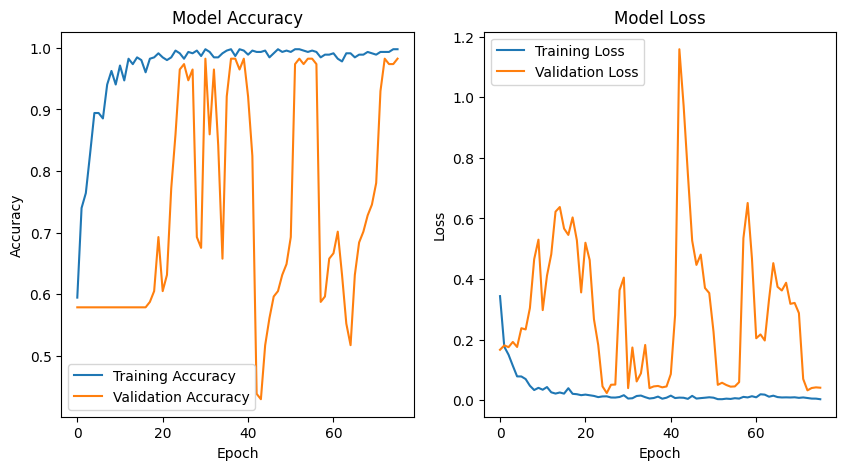

In [142]:
plot_history(history)

In [11]:
(1,X_train[0])

(1,
 array([0.69523633, 0.88638908, 0.60257071, ..., 0.52557355, 0.6112923 ,
        0.48786801]))

In [12]:
model.predict(X_train[0].reshape(1,2100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


array([[0.05514305, 0.9886841 ]], dtype=float32)